In [13]:
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, ParameterGrid

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [14]:
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

In [15]:
x_train = np.load('C:/Users/mikke/OneDrive - Syddansk Universitet/Data Science/10. Anvendt Maskinlæring/00 data_assignment_3/x_train.npy')
print(f'Shape of training data: {x_train.shape}')

x_test = np.load('C:/Users/mikke/OneDrive - Syddansk Universitet/Data Science/10. Anvendt Maskinlæring/00 data_assignment_3/x_test.npy')
print(f'Shape of test data: {x_test.shape}')

y_train = np.load('C:/Users/mikke/OneDrive - Syddansk Universitet/Data Science/10. Anvendt Maskinlæring/00 data_assignment_3/y_train.npy')
print(f'Shape of labels/targets: {y_train.shape}')

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Shape of training data: (20000, 48)
Shape of test data: (5000, 48)
Shape of labels/targets: (20000,)


In [16]:
x_train_copy = x_train
y_train_copy = y_train

num_ensembles = 3
samples_per_ensemble = x_train_copy.shape[0] // num_ensembles

np.random.seed(42)

datasets = {}

for i in range(1, 4):
    indices = np.random.choice(x_train_copy.shape[0], samples_per_ensemble, replace=False)

    X_subset = x_train_copy[indices]
    y_subset = y_train_copy[indices]

    datasets[f'X_{i}'] = X_subset
    datasets[f'y_{i}'] = y_subset

    x_train_copy = np.delete(x_train_copy, indices, axis=0)
    y_train_copy = np.delete(y_train_copy, indices, axis=0)

In [17]:
for i in range(1, 4):
    X = datasets[f'X_{i}']
    y = datasets[f'y_{i}']
    print(f"Shape of X_{i}: {X.shape}")
    print(f"Shape of y_{i}: {y.shape}")

Shape of X_1: (6666, 48)
Shape of y_1: (6666,)
Shape of X_2: (6666, 48)
Shape of y_2: (6666,)
Shape of X_3: (6666, 48)
Shape of y_3: (6666,)


## Hyperparameters for 3 Models:

<br>

**Model 1: FFNN**

**Model 2: Boosting**

**Model 3: Random Forest**

<br>

Each model is based on 1/3 of the training data.



**Model 1 (Hyperparameters search):**

In [18]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,)),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_1.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.experimental.Adagrad(0.0002),
    metrics=['mae'],
)

In [19]:
X_1 = datasets['X_1']
y_1 = datasets['y_1']

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae',
                                            patience=30,
                                            restore_best_weights=True)

model_1.summary()

history_1 = model_1.fit(
    X_1,
    y_1,
    epochs=10,
    verbose=1,
    validation_split=0.2,
    callbacks=callback
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_3 (Dense)             (None, 96)                4704      
                                                                 
 batch_normalization_2 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 48)                4656      
                                                                 
 batch_normalization_3 (Batc  (None, 48)               192       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 48)               

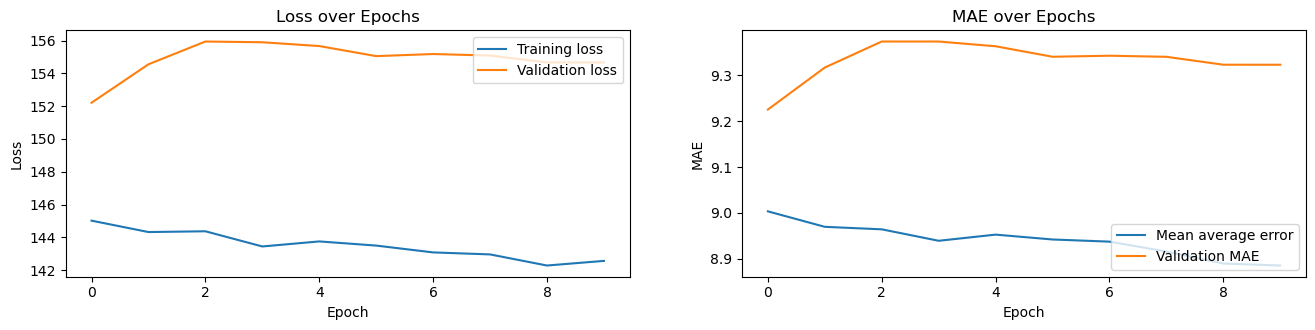

In [20]:
history_x = history_1
history_y = history_1

fig = plt.figure(figsize=plt.figaspect(0.2))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_x.history['loss'], label='Training loss')
ax.plot(history_y.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over Epochs')
plt.legend(loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_x.history['mae'], label='Mean average error')
ax.plot(history_y.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(f'MAE over Epochs')
plt.legend(loc='lower right')

plt.show()

**Model 2 (Hyperparameters search):**

In [11]:
X_2 = datasets['X_2']
y_2 = datasets['y_2']

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

param_grid = ParameterGrid({
    'n_estimators': [250, 500, 1000],
    'min_samples_split': [50, 250, 1000],
    'min_samples_leaf': [50, 250, 1000],
    'learning_rate': [0.01, 0.1, 0.75]
    })

score_ = 0
params_ = None

for params in param_grid:
  gbt_current = ensemble.GradientBoostingRegressor(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                learning_rate=params['learning_rate'],
                )
  gbt_current.fit(X_train_2, y_train_2)
  y_val_hat = gbt_current.predict(X_val_2)
  val_MAE = mean_absolute_error(y_val_hat, y_val_2)
  if val_MAE > score_:
    score_ = val_MAE
    params_ = params

KeyboardInterrupt: 

In [12]:
print(f"For GB the best hyperparameters are: {params_}, the mean average error of the model is: {val_MAE}")

For GB the best hyperparameters are: {'learning_rate': 0.5, 'min_samples_leaf': 10, 'min_samples_split': 250, 'n_estimators': 8000}, the mean average error of the model is: 8.066256368107819


**Model 3 (Hyperparameters search):**

In [21]:
X_3 = datasets['X_3']
y_3 = datasets['y_3']

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

param_grid = ParameterGrid({
    'n_estimators': [250, 500, 1000, 2000, 4000, 8000],
    'min_samples_split': [10, 20, 50, 100, 250],
    'min_samples_leaf': [10, 20, 50, 100, 250],
    'max_depth': [None, 30, 20, 15, 10, 3, 2],
    'max_features': ['sqrt', 'log2', 20, 10]
    })

score_ = 0
params_ = None
for params in param_grid:
  rf_current = ensemble.RandomForestRegressor(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                max_depth=params['max_depth'],
                max_features=params['max_features'],
                )
  rf_current.fit(X_train_3, y_train_3)
  y_val_hat = rf_current.predict(X_val_3)
  val_MAE = mean_absolute_error(y_val_hat, y_val_3)
  if val_MAE > score_:
    score_ = val_MAE
    params_ = params

KeyboardInterrupt: 

In [22]:
print(f"For RF the best hyperparameters are: {params_}, the mean average error of the model is: {val_MAE}")

For RF the best hyperparameters are: {'max_depth': None, 'max_features': 20, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 500}, the mean average error of the model is: 6.561423749354163


## Train the models with the chosen hyperparameters, and predict on the test data for kaggle upload.

**Dataframe for ensemble:**

In [ ]:
df_ensemble = pd.DataFrame()

**Model 1 (FFNN) predictions:**

In [ ]:
history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=10000,
    verbose=1,
    validation_split=0.2,
    callbacks=callback
)

y_test_hat_1 = model_1.predict(x_test)

df_ensemble['model_1'] = y_test_hat_1.reshape(-1)

**Model 2 (Boosting) predictions:**

In [152]:
model_2 = ensemble.GradientBoostingRegressor(
                n_estimators=8000,
                min_samples_split=250,
                min_samples_leaf=10,
                learning_rate=0.5,
                )

model_2.fit(x_train, y_train)
y_test_hat_2 = model_2.predict(x_test)

df_ensemble['model_2'] = y_test_hat_2

**Model 3 (Random Forest) predictions:**

In [153]:
model_3 = ensemble.RandomForestRegressor(
                n_estimators=1,
                min_samples_split=5,
                min_samples_leaf=1,
                max_depth=1,
                max_features=5,
                )

model_3.fit(x_train, y_train)
y_test_hat_3 = model_3.predict(x_test)

df_ensemble['model_3'] = y_test_hat_3

### The average prediction over the three models:

In [154]:
df_ensemble['average'] = df_ensemble.mean(axis=1)

print(df_ensemble)

       model_1    model_2    model_3    average
0     1.817711  11.240237  18.119663  10.392537
1     0.669273  11.240237  18.119663  10.009725
2     1.376598  11.240237  18.119663  10.245500
3     0.843585  11.240237  18.119663  10.067828
4     0.836160  11.240237  18.119663  10.065353
...        ...        ...        ...        ...
4995  2.591280  11.240237  18.119663  10.650394
4996  1.486662  11.240237  18.119663  10.282187
4997 -0.129863  11.240237  18.119663   9.743346
4998  0.737637  11.240237  18.119663  10.032513
4999  1.062864  11.240237  18.119663  10.140922

[5000 rows x 4 columns]
